In [1]:
! pip install astropy --user
! pip install matplotlib --user
! pip install sklearn --user
! pip install tqdm --user
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [239]:
import os
import tarfile
import gzip
import warnings
from urllib.request import urlopen

from astropy.table import Table
from astropy.io import fits
from astropy.units import UnitsWarning

import numpy as np
import numpy.core.defchararray as np_str
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.optimize import curve_fit

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from tqdm import tnrange

################################################################################

# Equivalent to default range(length), but also displays a progress bar with an
# estimate of the remaining time.
def progress_range(length):
    return tnrange(length, leave=False, smoothing=0.05,
                   bar_format='{n}/|/Estimated Time Remaining: {remaining}')

################################################################################

# Speed of light in angstroms per second.
speed_of_light = 2.99792458e18

# Planck's constant in kiloelectronvolt-seconds.
planck_constant = 44173801/1.06811756e25

################################################################################

# Directory which contains zCOSMOS-deep catalogue; may be set to None. This
# catalogue is not publicly available, so it cannot be downloaded automatically.
zdeep_dirname = None

# Name of zCOSMOS-bright catalogue file, which can be extracted from
# https://irsa.ipac.caltech.edu/data/COSMOS/spectra/z-cosmos/zCOSMOS20kDR3.tar.
# Downloading the entire 6GB tar for a single file is absurd, so it is not done
# automatically.
zbright_filename = 'zCOSMOS_VIMOS_BRIGHT_DR3_CATALOGUE.fits'

# Directory in which to automatically download all other reqiured files.
download_dirname = 'downloads'

# Names of the COSMOS2015 catalogue file, the FMOS catalogue directory, and the
# LEGA-C catalogue directory.
cosmos_filename = os.path.join(download_dirname, 'COSMOS2015_Laigle+_v1.1.fits')
fmos_dirname = os.path.join(download_dirname, 'FMOS')
legac_dirname = os.path.join(download_dirname, 'LEGA-C')

################################################################################

# If necessary, downloads the COSMOS2015, FMOS, and LEGA-C catalogues.
def check_downloads():
    if not os.path.exists(download_dirname):
        os.makedirs(download_dirname, exist_ok=True)
    
    if not os.path.exists(cosmos_filename):
        url = ('ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/'
               'COSMOS2015_Laigle+_v1.1.fits.gz')
        print('Downloading', url, end =' ')
        with open(cosmos_filename, 'wb') as decompressed_file:
            decompressed_file.write(gzip.decompress(urlopen(url).read()))
        print('[Done]')
    
    for url, old_dirname, new_dirname in (('http://member.ipmu.jp/fmos-cosmos/'
                                           'FC_spectra_files/1dspec.tar.gz',
                                           '1dspec', fmos_dirname),
                                          ('http://www2.mpia-hd.mpg.de/home/'
                                           'legac/dr2/legac_dr2_spectra.tar.gz',
                                           'spectraDR', legac_dirname)):
        if not os.path.exists(new_dirname):
            print('Downloading', url, end =' ')
            with tarfile.open(fileobj=urlopen(url), mode='r|gz') as tar_file:
                tar_file.extractall()
            os.rename(old_dirname, new_dirname)
            print('[Done]')

################################################################################

# For every galaxy in the COSMOS2015 catalogue, record that galaxy's
# coordinates (in degrees), its flux through every filter (in erg/s/cm^2/Hz),
# and the error in every flux (in erg/s/cm^2/Hz). Correct the fluxes to account
# for aperture size and foreground extinction. In a separate table, record every
# filter's name and its transmission data (if no transmission data is available,
# simply record its edge wavelengths).
def load_phot_filter_tables():           
    # Read the entire COSMOS2015 catalog, ignoring the warning about poorly
    # formatted units. The table is masked because there are missing values in
    # the ID_XMM, ID_CHANDRA09, and FLAG_XRAYBLEND columns; since those columns
    # are irrelevant, it can be converted to a regular table.
    #with warnings.catch_warnings():
        #warnings.simplefilter('ignore', UnitsWarning)
        #cosmos_table = Table.read(cosmos_filename).filled()
        
    # Ignore every object that is not a galaxy.
    cosmos_table.remove_rows(cosmos_table['TYPE'] != 0)
    
    # Ignore all masked galaxies.
    cosmos_table.remove_rows(cosmos_table['FLAG_PETER'] != 0)
    
    # Create a list for the columns of the photometric data table, along with a
    # list for their names. Initialize the lists so that they describe the
    # coordinates of each galaxy.
    phot_columns = [cosmos_table['ALPHA_J2000'].data,
                    cosmos_table['DELTA_J2000'].data]
    phot_colnames = ['ra', 'dec']
    
    # Create a list for the rows of the filter data table.
    filter_rows = []
    
    # Record the name of each filter, its description in the COSMOS2015
    # catalogue header, a word that specifies the location of its transmission
    # data file, the name of its transmission data file, and its systematic
    # offset and foreground extinction factor (from columns 4 and 5 of Table 3
    # in the COSMOS2015 paper, https://arxiv.org/pdf/1604.02350.pdf; the values
    # for z+ and GALEX FUV are assumed to be the same as those of z++ and GALEX
    # NUV, respectively, while all other unknown values are assumed to be 0).
    # The NuSTAR filters are not included, since they were not used to measure
    # the fluxes of any galaxies.
    filter_data = [
    ('yHSC',          'O/NIR', 'faisst', 'y_HSC.txt',             -0.014, 1.298),
    ('Y',             'O/NIR', 'capak',  'Y_uv.res',               0.001, 1.211),
    ('J',             'O/NIR', 'capak',  'J_uv.res',               0.017, 0.871),
    ('H',             'O/NIR', 'capak',  'H_uv.res',               0.055, 0.563),
    ('Ks',            'O/NIR', 'capak',  'K_uv.res',              -0.001, 0.364),
    ('Ksw',           'O/NIR', 'capak',  'wircam_Ks.res',          0.068, 0.364),
    ('Hw',            'O/NIR', 'capak',  'wircam_H.res',          -0.031, 0.563),
    ('u',             'O/NIR', 'capak',  'u_megaprime_sagem.res',  0.010, 4.660),
    ('B',             'O/NIR', 'capak',  'B_subaru.res',           0.146, 4.020),
    ('V',             'O/NIR', 'capak',  'V_subaru.res',          -0.117, 3.117),
    ('r',             'O/NIR', 'capak',  'r_subaru.res',          -0.012, 2.660),
    ('ip',            'O/NIR', 'capak',  'i_subaru.res',           0.020, 1.991),
    ('zp',            'O/NIR', 'capak',  'z_subaru.res',          -0.084, 1.461),
    ('zpp',           'O/NIR', 'capak',  'suprime_FDCCD_z.res',   -0.084, 1.461),
    ('IB427',         'O/NIR', 'capak',  'IB427.SuprimeCam.pb',    0.050, 4.260),
    ('IB464',         'O/NIR', 'capak',  'IB464.SuprimeCam.pb',   -0.014, 3.843),
    ('IA484',         'O/NIR', 'capak',  'IB484.SuprimeCam.pb',   -0.002, 3.621),
    ('IB505',         'O/NIR', 'capak',  'IB505.SuprimeCam.pb',   -0.013, 3.425),
    ('IA527',         'O/NIR', 'capak',  'IB527.SuprimeCam.pb',    0.025, 3.264),
    ('IB574',         'O/NIR', 'capak',  'IB574.SuprimeCam.pb',    0.065, 2.937),
    ('IA624',         'O/NIR', 'capak',  'IB624.SuprimeCam.pb',   -0.010, 2.694),
    ('IA679',         'O/NIR', 'capak',  'IB679.SuprimeCam.pb',   -0.194, 2.430),
    ('IA738',         'O/NIR', 'capak',  'IB738.SuprimeCam.pb',    0.017, 2.289),
    ('IA767',         'O/NIR', 'capak',  'IB767.SuprimeCam.pb',    0.020, 2.150),
    ('IB709',         'O/NIR', 'capak',  'IB709.SuprimeCam.pb',    0.024, 1.996),
    ('IB827',         'O/NIR', 'capak',  'IB827.SuprimeCam.pb',   -0.005, 1.747),
    ('NB711',         'O/NIR', 'capak',  'NB711.SuprimeCam.pb',    0.040, 2.268),
    ('NB816',         'O/NIR', 'capak',  'NB816.SuprimeCam.pb',   -0.035, 1.787),
    ('SPLASH_1',      'IRAC',  'capak',  'irac_ch1.res',          -0.025, 0.162),
    ('SPLASH_2',      'IRAC',  'capak',  'irac_ch2.res',          -0.005, 0.111),
    ('SPLASH_3',      'IRAC',  'capak',  'irac_ch3.res',          -0.061, 0.075),
    ('SPLASH_4',      'IRAC',  'capak',  'irac_ch4.res',          -0.025, 0.045),
    ('GALEX_NUV',     'Other', 'capak',  'galex2500.res',          0.128, 8.621),
    ('GALEX_FUV',     'Other', 'capak',  'galex1500.res',          0.128, 8.621),
    ('24',            'Other', 'capak',  'mips24.res',             0.000, 0.000),
    ('100',           'Other', 'capak',  'PACS_filter_100.txt',    0.000, 0.000),
    ('160',           'Other', 'capak',  'PACS_filter_160.txt',    0.000, 0.000),
    ('250',           'Other', 'capak',  'SPIRE_filter_250.txt',   0.000, 0.000),
    ('350',           'Other', 'capak',  'SPIRE_filter_350.txt',   0.000, 0.000),
    ('500',           'Other', 'capak',  'SPIRE_filter_500.txt',   0.000, 0.000),
    ('814W',          'Other', 'svo',    'ACS_HRC.F814W',          0.000, 0.000),
    ('20CM',          'VLA',    None,     None,                    0.000, 0.000),
    ('90CM',          'VLA',    None,     None,                    0.000, 0.000),
    ('CHANDRA_0.5_2', 'X-Ray',  None,     None,                    0.000, 0.000),
    ('CHANDRA_2_10',  'X-Ray',  None,     None,                    0.000, 0.000),
    ('XMM_0.5_2',     'X-Ray',  None,     None,                    0.000, 0.000),
    ('XMM_2_10',      'X-Ray',  None,     None,                    0.000, 0.000)]
    
    for name, description, location, filename, offset, factor in filter_data:
        # Determine the name of the column in the COSMOS2015 catalogue that
        # contains the fluxes for this filter, along with the name of the column
        # that contains the errors for those fluxes (if available).
        if description == 'O/NIR':
            flux_colname = name + '_FLUX_APER3'
            error_colname = name + '_FLUXERR_APER3'
        elif description == 'IRAC':
            flux_colname =  name + '_FLUX'
            error_colname = name + '_FLUX_ERR'
        elif description == 'VLA':
            flux_colname = 'FLUXINT_' + name
            error_colname = 'FLUXINTERR_' + name
        elif description == 'X-Ray':
            flux_colname = 'FLUX_' + name
            error_colname = None
        else:
            flux_colname = 'FLUX_' + name
            error_colname = 'FLUXERR_' + name
            
        # Get the columns that contain the fluxes and errors for this filter.
        # Replace every unknown flux and its corresponding error with NaN (a
        # flux is unknown when its error is negative). If no errors are
        # available, denote every error by NaN.
        flux_col = cosmos_table[flux_colname]
        if error_colname:
            error_col = cosmos_table[error_colname]
            is_unknown = np.less_equal(error_col, 0,
                                       out=np.full(len(cosmos_table), True),
                                       where=~np.isnan(error_col))
            flux_col[is_unknown] = np.nan
            error_col[is_unknown] = np.nan
        else:
            error_col = flux_col.copy()
            error_col[:] = np.nan
        
        # Calculate the factor by which each flux must be multiplied to be in
        # CGS units (erg/s/cm^2/Hz). Most fluxes are in multiples of Janskys, so
        # the conversion is simple because 1 Jy = 1e-23 erg/s/cm^2/Hz. The X-Ray
        # fluxes are given as ordinary fluxes instead of flux densities with
        # respect to frequency, so they must be divided by the width of the
        # filter in Hz, which can be determined from the name of the filter.
        # Although the values that correspond to the 814W filter are labeled as
        # fluxes in mJy, they are actually AB magnitudes, so they must be
        # converted to fluxes and their errors must be corrected appropriately.
        if name == '814W':
            flux_col = 10.0 ** (-0.4 * (flux_col + 48.6))
            error_col = np.abs(-0.4 * np.log(10.0) * flux_col) * error_col
            to_cgs = 1
        elif flux_col.unit == 'uJy':
            to_cgs = 1e-29
        elif flux_col.unit == 'mJy':
            to_cgs = 1e-26
        elif flux_col.unit == 'erg / (cm2 s)':
            energies = list(map(float, name.split('_')[1:]))
            to_cgs = planck_constant / (energies[1] - energies[0])
        
        # Calculate the correction factor for the fluxes. As specified in the
        # appendix of the COSMOS2015 paper, the AB magnitude m of an object with
        # photometric offset o and reddenning value EBV that is measured through
        # a filter with systematic offset s and extinction factor F should be
        # corrected to m + o - s - EBV * F.
        correction = 10.0 ** (-0.4 * (cosmos_table['OFFSET'] - offset -
                                      cosmos_table['EBV'] * factor))
    
        # Add the corrected fluxes and errors in CGS units to the list of
        # photometric data table columns, and update the list of column names.
        phot_columns.append(flux_col.data * to_cgs * correction)
        phot_columns.append(error_col.data * to_cgs * correction)
        phot_colnames.append(name)
        phot_colnames.append(name + '_ERR')
        
        # If it exists, get the transmission data for this filter, and use it to
        # determine the wavelengths the filter covers and the fraction of flux
        # that is transmitted at each wavelength, ignoring every leading and
        # trailing 0 in the list of transmissions. Otherwise, only determine the
        # minimum and maximum wavelengths, and denote the transmissions by None.
        # The wavelengths of the VLA filters can be determined using the
        # frequencies from https://science.nrao.edu/facilities/vla/docs/manuals/
        # oss2013B/performance/bands, and the wavelengths of the X-Ray filters
        # can be determined from the energies calculated earlier.
        if filename:
            if location == 'capak':
                path = 'http://www.astro.caltech.edu/~capak/filters/'
            elif location == 'faisst':
                path = ('http://www.astro.caltech.edu/~afaisst/files/'
                        'cosmos_filter/')
            elif location == 'svo':
                path = ('http://svo2.cab.inta-csic.es/svo/theory/fps3/'
                        'getdata.php?format=ascii&id=HST/')
            transmission_data = Table.read(path + filename, format='ascii')
            wavelengths = transmission_data.columns[0].data.astype('f')
            transmissions = transmission_data.columns[1].data
            is_nonzero = transmissions != 0
            index1 = np.argmax(is_nonzero)
            index2 = len(is_nonzero) - is_nonzero[::-1].argmax()
            wavelengths = wavelengths[index1:index2]
            transmissions = transmissions[index1:index2]
        else:
            if name == '20CM':
                wavelengths = speed_of_light / np.array([2e9, 1e9])
            elif name == '90CM':
                wavelengths = speed_of_light / np.array([0.47e9, 0.23e9])
            else:
                wavelengths = (speed_of_light * planck_constant /
                               np.array(energies)[::-1])
            transmissions = None
            
        # Use the transmission data to determine the average wavelength of light
        # that passes through the filter.
        avg_wavelength = np.average(wavelengths, weights=transmissions)
        
        # Add the filter information to the list of filter data table rows.
        filter_rows.append((name, avg_wavelength, wavelengths, transmissions))

    # Convert all the photometric data and filter data into tables.
    phot_table = Table(phot_columns, names=phot_colnames)
    filter_table = Table(rows=filter_rows,
                         names=('name', 'avg_wavelength', 'wavelengths',
                                'transmissions'))
    return phot_table, filter_table

################################################################################

# For every spectrum file, load the name of the catalogue that led to the file
# and the path to the file (either a url or a file system path), along with the
# the coordinates and spectroscopic redshift of the galaxy associated with each
# spectrum. If bad redshifts are ignored, spectra with unknown or 0 redshifts
# are not included; otherwise, every unknown redshift is denoted by NaN.
def load_spec_table(ignore_bad_zs=True):
    ras = []
    decs = []
    names = []
    paths = []
    zs = []
    
    # Record the data from a particular catalogue.
    def add_data(catalogue_name, catalogue_table,
                 ra_colname, dec_colname, path_list,
                 ra_fun=None, dec_fun=None, path_fun=None,
                 z_colname=None, unknown_z_value=None, unknown_z_value2=None,
                 star_colname=None, star_value=None, star_substr=None):
        # Remove all stars from the catalogue if they are indicated in some
        # column. Either compare the values in that column to some value, or
        # search the strings in that column for some substring.
        if star_colname:
            star_col = catalogue_table[star_colname]
            if star_substr:
                is_star = np_str.find(np_str.lower(star_col), star_substr) != -1
            else:
                is_star = star_col == star_value
            catalogue_table.remove_rows(is_star)

        # Record the redshifts from the catalogue, if they are indicated in some
        # column. Otherwise, use NaN for every redshift.
        if z_colname:
            # If unknown redshifts are indicated by some value, either remove
            # all rows with unknown redshifts, or replace every unknown redshift
            # with NaN, depending on whether bad redshifts should be ignored. If
            # the redshifts weren't already floating-point values, convert them.
            if unknown_z_value:
                z_col = catalogue_table[z_colname]
                if (ignore_bad_zs and z_col.dtype.kind == 'f' and
                    np.isnan(unknown_z_value)):
                    catalogue_table.remove_rows(np.isnan(z_col))
                else:
                    unknown_zs = z_col == unknown_z_value
                    if unknown_z_value2:
                        unknown_zs = np.logical_or(unknown_zs,
                                                   z_col == unknown_z_value2)
                    if ignore_bad_zs:
                        catalogue_table.remove_rows(unknown_zs)
                    else:
                        z_col[unknown_zs] = z_col.dtype.type(np.nan)
                    if z_col.dtype.kind != 'f':
                        float_z_col = catalogue_table[z_colname].astype('f')
                        catalogue_table.replace_column(z_colname, float_z_col)

            # If bad redshifts should be ignored, remove all rows with 0
            # redshifts.
            if ignore_bad_zs:
                zero_zs = catalogue_table[z_colname] == 0
                catalogue_table.remove_rows(zero_zs)

            new_zs = catalogue_table[z_colname]
        else:
            new_zs = np.full(len(catalogue_table), np.nan)

        # Record the coordinates from the catalogue, optionally applying a
        # function to each coordinate.
        new_ras = catalogue_table[ra_colname]
        new_decs = catalogue_table[dec_colname]
        if ra_fun:
            new_ras = np.vectorize(ra_fun)(new_ras)
        if dec_fun:
            new_decs = np.vectorize(dec_fun)(new_decs)

        # Record the paths to the spectra from the catalogue. For each string in
        # the path list, if the string is the name of a column, add the strings
        # in that column to the paths, optionally applying a function to each
        # string. Otherwise, just add the string to each path.
        new_paths = np.full(len(catalogue_table), '')
        for string in path_list:
            if string in catalogue_table.colnames:
                path_col = catalogue_table[string].astype('U')
                if path_fun:
                    path_col = np.vectorize(path_fun)(path_col)
                new_paths = np_str.add(new_paths, path_col)
            else:
                new_paths = np_str.add(new_paths, string)

        # Add all the recorded information to the given lists.
        ras.append(new_ras)
        decs.append(new_decs)
        names.append(np.full(len(catalogue_table), catalogue_name))
        paths.append(new_paths)
        zs.append(new_zs)
    
    #-----------------------------------IPAC-----------------------------------#
    
    # Record the url that will be prepended to every IPAC path.
    ipac_url = 'https://irsa.ipac.caltech.edu/data/COSMOS/'
    
    # Load the DEIMOS catalogue.
    deimos_catalogue = Table.read(ipac_url + 'tables/spectra/' +
                                  'deimos_redshift_linksIRSA.tbl',
                                  format='ipac')
    
    # Ignore all rows without paths to the associated spectra.
    deimos_catalogue.remove_rows(deimos_catalogue['ascii1d'].mask)

    # Since some paths were missing, the table is masked. Convert the
    # masked table to a regular table.
    deimos_catalogue = deimos_catalogue.filled()
    
    # Add the data from the DEIMOS catalogue.
    add_data('DEIMOS', deimos_catalogue, 'ra', 'dec', [ipac_url, 'fits1d'],
             path_fun=lambda s: s.split('"')[1][13:], z_colname='zspec',
             unknown_z_value='NA', star_colname='Remarks', star_substr='star')
    
    # Add the data from the Magellan catalogue.
    add_data('Magellan',
             Table.read(ipac_url + 'tables/spectra/magellan_opt_spec_30.tbl',
                        format='ipac'),
             'ra', 'dec', [ipac_url, 'FITS_u'], z_colname='redshift',
             unknown_z_value=-1, star_colname='class', star_value='star')
    
    # Add the data from the zCOSMOS-bright catalogue, which does not indicate
    # stars.
    add_data('zCOSMOS-bright', Table.read(zbright_filename),'RAJ2000',
             'DEJ2000', [ipac_url + 'spectra/z-cosmos/DR3/', 'FILENAME'],
             z_colname='REDSHIFT', unknown_z_value=np.nan)
        
    #-----------------------------------C3R2-----------------------------------#
        
    # Converts a string of the form hh:mm:ss to degrees.
    def ra_to_deg(s):
        return 15 * float(s[0:2]) + float(s[3:5]) / 4 + float(s[6:]) / 240

    # Converts a string of the form (+/-)dd:mm:ss to degrees.
    def dec_to_deg(s):
        if s[0] == '+':
            return float(s[1:3]) + float(s[4:6]) / 60 + float(s[7:]) / 3600
        elif s[0] == '-':
            return -float(s[1:3]) - float(s[4:6]) / 60 - float(s[7:]) / 3600
        else:
            return float(s[0:2]) + float(s[3:5]) / 60 + float(s[6:]) / 3600
    
    # Record the url that will be prepended to every C3R2 path.
    c3r2_url = 'https://koa.ipac.caltech.edu/data/Contributed/C3R2/'
    
    # Add the data from the C3R2 catalogue, which does not indicate unknown
    # redshifts or stars, and which does not come with column names.
    add_data('C3R2',
             Table.read(c3r2_url + 'c3r2_targets_2019mar28.txt', data_start=17,
                        format='ascii.no_header'),
             'col2', 'col3', [c3r2_url + 'spec1d/', 'col10'],
             ra_fun=ra_to_deg, dec_fun=dec_to_deg, z_colname='col7')
    
    #-----------------------------------FMOS-----------------------------------#
    
    # Record the first part of the path list for every FMOS path.
    fmos_path_list = [fmos_dirname + os.path.sep, 'FMOS_ID', '_']

    # Load the FMOS catalogue.
    fmos_catalogue = Table.read('http://member.ipmu.jp/fmos-cosmos/'
                                'FC_catalogs_files/FMOS_COSMOS_v1.0.fits')

    # Add the data for H-Long spectra from the FMOS catalogue.
    add_data('FMOS', fmos_catalogue, 'RA', 'DEC',
             fmos_path_list + ['DATE_OBS_HL', '_hl_1d.fits'], z_colname='ZSPEC',
             unknown_z_value=-999, star_colname='TYPE', star_value=1)

    # Ignore all rows that do not have associated J-Long spectra.
    fmos_catalogue.remove_rows(fmos_catalogue['OBS_JL'] == 0)

    # Add the data for J-Long spectra from the FMOS catalogue. Since all the
    # stars were already removed and all the bad redshifts were already
    # removed/replaced, there is no need to pass that information again.
    add_data('FMOS', fmos_catalogue, 'RA', 'DEC',
             fmos_path_list + ['DATE_OBS_JL', '_jl_1d.fits'], z_colname='ZSPEC')
    
    #----------------------------------LEGA-C----------------------------------#
    
    # Add the data from the LEGA-C catalogue, which does not indicate stars.
    # Ignore the warning about poorly formatted units.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UnitsWarning)
        add_data('LEGA-C',
                 Table.read('http://www.mpia.de/home/legac/dr2/'
                            'legac_dr2_cat.fits.gz'),
                 'RAJ2000', 'DECJ2000',
                 [legac_dirname + os.path.sep, 'Filename'],
                 path_fun=lambda s: s.rstrip(' '),
                 z_colname='z', unknown_z_value=np.nan)
    
    #-------------------------------ZCOSMOS-DEEP-------------------------------#
    
    # If it exists, add the data from the zCOSMOS-deep catalogue, which does not
    # indicate stars.
    if zdeep_dirname:
        add_data('zCOSMOS-deep',
                 Table.read(os.path.join(zdeep_dirname, 'catalogs', 'DEEP_'
                                         'zcosmos_spectroscopy_one_v2.6.data'),
                            format='ascii'),
                 'ra', 'dec',
                 [os.path.join(zdeep_dirname, 'spectra', 'LB'), 'pointing',
                  os.path.join(os.path.sep + '1DFiles', 'sc_000'), 'id',
                  '_ZCLBa', 'pointing', '_M1_blue_', 'slit', '_', 'obj',
                  '_cal_clean.fits'],
                 z_colname='zspec', unknown_z_value=9.9999,
                 unknown_z_value2=9.999)
    
    #--------------------------------------------------------------------------#
    
    # Convert all the gathered data into a single table.
    return Table(list(map(np.concatenate, (ras, decs, names, paths, zs))),
                 names=('ra', 'dec', 'name', 'path', 'z'))

################################################################################

# Given two arrays that specify points (x1, y1) and two arrays that specify
# points (x2, y2), find all pairs of indices (index1, index2) for which the
# point (x1, y1) at index1 and the point (x2, y2) at index2 have coordinates
# such that abs(x1 - x2) and abs(y1 - y2) are less than the specified tolerance
# tol. If duplicates are not allowed, only the closest match for (x1, y1) is
# selected; i.e., if (x1, y1) and (x2, y2) are selected, there is no other point
# (x2, y2) that is closer to (x1, y1).
def find_matches(x_array1, y_array1, x_array2, y_array2, tol,
                 allow_duplicates=False):
    # Get the lengths of the x-arrays (which are the same as the lengths of the
    # corresponding y-arrays).
    length1 = len(x_array1)
    length2 = len(x_array2)
    
    # Get the indices that sort the x-arrays and use them to sort the arrays.
    sorting_indices1 = np.argsort(x_array1)
    sorting_indices2 = np.argsort(x_array2)
    sorted_x_array1 = x_array1[sorting_indices1]
    sorted_x_array2 = x_array2[sorting_indices2]
    
    if allow_duplicates:
        # Initialize two lists of matching indices.
        matching_indices1 = []
        matching_indices2 = []
        
    else:
        # Initialize dictionaries that map the incides of points (x1, y1) to
        # their closest matches (x2, y2) and to the distances to those matches.
        index1_to_index2 = {}
        index1_to_dist = {}
    
    # Iterate through the sorted x-arrays, looking for two x-coordinates x1 and
    # x2 within tol of each other. When two such x-coordinates are found, check
    # whether the corresponding y-coordinates y1 and y2 are also within tol of
    # each other.
    sorted_index2 = 0
    for sorted_index1 in progress_range(length1):
        # Get x1, the x-coordinate at the current index in the first sorted
        # x-array.
        x1 = sorted_x_array1[sorted_index1]

        # Iterate through the second sorted x-array until x1 < x2' + tol, where
        # x2' is the x-coordinate at the current index in the second sorted
        # x-array.
        while (sorted_index2 < length2 and
               x1 >= sorted_x_array2[sorted_index2] + tol):
            sorted_index2 += 1

        # Iterate through the second sorted x-array while x1 > x2 - tol, where
        # x2 is an x-coordinate at or after the current index in the second
        # sorted x-array. Since x2 >= x2' and x1 < x2' + tol, it must be the
        # case that x1 < x2 + tol. Therefore, x1 and x2 are within tol of each
        # other when x1 > x2 - tol.
        temp_sorted_index2 = sorted_index2
        while (temp_sorted_index2 < length2 and
               x1 > sorted_x_array2[temp_sorted_index2] - tol):
            # Get the indices of x1 and x2 in the original (unsorted) x-arrays.
            index1 = sorting_indices1[sorted_index1]
            index2 = sorting_indices2[temp_sorted_index2]
            
            # Get the y-coordinates y1 and y2 that correspond to x1 and x2.
            y1 = y_array1[index1]
            y2 = y_array2[index2]
            
            # Check whether y1 and y2 are also within tol of each other.
            if y1 < y2 + tol and y1 > y2 - tol:
                if allow_duplicates:
                    matching_indices1.append(index1)
                    matching_indices2.append(index2)
                
                else:
                    x2 = sorted_x_array2[temp_sorted_index2]
                    dist = np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

                    # If there is no closer match for (x1, y1), update the
                    # dictionaries.
                    if (index1 not in index1_to_dist or
                        dist < index1_to_dist[index1]):
                        index1_to_dist[index1] = dist
                        index1_to_index2[index1] = index2
            
            temp_sorted_index2 += 1
    
    # Return the closest matches as two arrays, with each index1 in the
    # first array and each corresponding index2 in the second array.
    if allow_duplicates:
        return matching_indices1, matching_indices2
    else:
        return (np.array(list(index1_to_index2.keys())),
                np.array(list(index1_to_index2.values())))

################################################################################

# Given the spectroscopic table, determine errors for the zCOSMOS-bright spectra
# by interpolating/axtrapolating the median errors of the LEGA-C spectra, since
# both were measured with the same instrument.
def get_zbright_errors(spec_table):
    # Load the parts of the spectroscopic table related to each catalogue.
    legac_table = spec_table[spec_table['name'] == 'LEGA-C']
    zbright_table = spec_table[spec_table['name'] == 'zCOSMOS-bright']
    
    # Record the wavelengths used in each catalogue by looking at the first
    # spectrum in each catalogue.
    with fits.open(legac_table['path'][0]) as hdus:
        legac_wavelengths = hdus[1].data[0][0]
    with fits.open(zbright_table['path'][0]) as hdus:
        zbright_wavelengths = hdus[1].data[0][0]
        
    # Record all of the errors in the LEGA-C catalogue. This may take some time.
    errors = np.zeros((len(legac_wavelengths), len(legac_table)))
    for spectrum_num in progress_range(len(legac_table)):
        with fits.open(legac_table['path'][spectrum_num]) as hdus:
            errors[:, spectrum_num] = hdus[1].data[0][2]
    
    # An unknown error is denoted by either 0 or NaN. Convert every 0 to an NaN.
    errors = np.where(errors == 0, np.nan, errors)
    
    # The distribution of errors at every wavelength is quite erratic, with
    # a few values on the order of 1e5 interspersed among values on the order of
    # 10. If the mean of the errors at every wavelength is calculated, the large
    # values dominate the mean, even though they do not convey much information.
    # Therefore, the median of the errors should be calculated instead of the
    # mean. Furthermore, there are a lot of unknown errors at very short and
    # very long wavelengths, which causes the median errors at those wavelengths
    # to oscillate chaotically. This can be avoided by only using wavelengths at
    # which a sufficient number of errors are known.
    is_enough_known = np.sum(~np.isnan(errors), axis=1) >= 100
    legac_wavelengths = legac_wavelengths[is_enough_known]
    median_errors = np.nanmedian(errors[is_enough_known], axis=1)
        
    # Record the indices that separate the zCOSMOS-bright wavelengths that
    # overlap with the remaining LEGA-C wavelengths from those that do not.
    index1 = np.argmax(zbright_wavelengths >= legac_wavelengths[0])
    index2 = np.argmax(zbright_wavelengths >= legac_wavelengths[-1])
    
    # Interpolate the median errors to the zCOSMOS-bright wavelengths that
    # overlap with the LEGA-C wavelengths.
    interpolation = interp1d(legac_wavelengths, median_errors)
    interp_errors = interpolation(zbright_wavelengths[index1:index2])
    
    # Extrapolate the median errors to the zCOSMOS-bright wavelengths that do
    # not overlap with the LEGA-C wavelengths. In order to improve the
    # extrapolation, use a median filter to remove the effects of atmosphereic
    # emission/absorption lines from the errors, leaving behind just the effects
    # of the instrumentation. Then, fit the sum of two exponentials and a
    # constant to the filtered errors at short and long wavelengths, and
    # evaluate the fitted function at the non-overlapping wavelengths.
    def fitting_fun(x, a1, b1, a2, b2, c):
        return a1 * np.exp(b1 * x) + a2 * np.exp(b2 * x) + c
    num_to_fit = 700
    fitting_wavelengths = np.concatenate((legac_wavelengths[:num_to_fit],
                                          legac_wavelengths[-num_to_fit:]))
    filtered_errors = medfilt(median_errors, 81)
    fitting_errors = np.concatenate((filtered_errors[:num_to_fit],
                                     filtered_errors[-num_to_fit:]))
    params = curve_fit(fitting_fun, fitting_wavelengths, fitting_errors,
                       p0=(1e18, -1e-3, 1e-30, 1e-2, 1), maxfev=100000)[0]
    extrap_errors1 = fitting_fun(zbright_wavelengths[:index1], *params)
    extrap_errors2 = fitting_fun(zbright_wavelengths[index2:], *params)
    
    # Combine the interpolated and extrapolated errors.
    return np.concatenate((extrap_errors1, interp_errors, extrap_errors2))

# Given the name of a catalogue and the path to a spectrum file (in FITS format)
# from that catalogue, return an array of wavelengths (in Angstroms), an array
# of corresponding fluxes (in arbitrary units), and an array of errors on those
# fluxes. Ignore all 0 fluxes, and ignore all fluxes with errors of 0 or NaN. If
# the file records flux errors, the errors may be scaled so that their average
# is the standard deviation of the flux noise. Otherwise, downsample the fluxes
# into bins with the given number of wavelengths, and use the standard devaition
# of each bin as its error. Although zCOSMOS-bright files do not record flux
# errors, an array of appropriate errors may be passed, and these errors will be
# scaled to match the noise.
def read_spec_file(name, path, zbright_errors=None, scale_errors=False,
                   wavelengths_per_bin=5):
    with fits.open(path, cache=False) as hdus:
        if name == 'zCOSMOS-bright':
            wavelengths = hdus[1].data['WAVE'][0]
            fluxes = hdus[1].data['FLUX_REDUCED'][0]
            errors = zbright_errors
        elif name == 'DEIMOS' or name == 'C3R2':
            inverse_variances = hdus[1].data['IVAR'][0]
            is_nonzero = inverse_variances != 0
            wavelengths = hdus[1].data['LAMBDA'][0][is_nonzero]
            fluxes = hdus[1].data['FLUX'][0][is_nonzero]
            errors = np.reciprocal(np.sqrt(inverse_variances[is_nonzero]))
        elif name == 'LEGA-C':
            errors = hdus[1].data['ERR'][0]
            is_nonzero = np.logical_and(~np.isnan(errors), errors != 0)
            wavelengths = hdus[1].data['WAVE'][0][is_nonzero]
            fluxes = hdus[1].data['FLUX'][0][is_nonzero]
            errors = errors[is_nonzero]
        elif name == 'Magellan':
            fluxes = hdus[0].data[1]
            is_nonzero = fluxes != 0
            wavelengths = hdus[0].data[0][is_nonzero]
            fluxes = fluxes[is_nonzero]
            errors = hdus[0].data[2][is_nonzero]
        
        # The spectrum files from the remaining catalogues do not record flux
        # errors. While they also do not record all the wavelengths, they do
        # record the smallest wavelength, the difference between consecutive
        # wavelengths, and the total number of wavelengths, which can be used to
        # reconstruct all the wavelengths.
        else:
            head = hdus[0].header
            errors = None
            if name == 'zCOSMOS-deep':
                wavelengths = (head['CRVAL1'] +
                               head['CDELT1'] * np.arange(head['NAXIS1']))
                fluxes = hdus[0].data[0]
            elif name == 'FMOS':
                fluxes = hdus[0].data
                is_nonzero = fluxes != 0
                wavelengths = (head['CRVAL1'] +
                               head['CD1_1'] * np.arange(head['NAXIS1']))
                wavelengths = wavelengths[is_nonzero]
                fluxes = fluxes[is_nonzero]
    
    # If there are no errors, downsample the fluxes into bins that each contain
    # wavelengths_per_bin wavelengths, and then obtain errors for each of the
    # bins. Otherwise, if necessary, scale the errors so that their average
    # coincides with the standard deviation of the difference between the actual
    # fluxes and the background fluxes (obtained by applying a median filter).
    if errors is None:
        truncated_length = wavelengths_per_bin * int(len(wavelengths) /
                                                     wavelengths_per_bin)
        bins = wavelengths[:truncated_length].reshape(-1, wavelengths_per_bin)
        bin_fluxes = fluxes[:truncated_length].reshape(-1, wavelengths_per_bin)
        wavelengths = np.mean(bins, axis=1)
        fluxes = np.mean(bin_fluxes, axis=1)
        errors = np.std(bin_fluxes, axis=1)
    elif scale_errors or name == 'zCOSMOS-bright':
        errors *= np.std(fluxes - medfilt(fluxes, 81)) / np.mean(errors)
        
    return (wavelengths.astype('f8'), fluxes.astype('f8'), errors.astype('f8'))

################################################################################

# Modify the fluxes and errors of the spectrum to match the available filter
# data, using an iterative algorithm to repeatedly multiply each flux by some
# correction factor. End the iterative algorithm when every correction factor is
# between 1 - cutoff and 1 + cutoff. Return whether or not the calibration was
# successful (i.e., whether there was at least one available filter flux and the
# correction factors converged to 1 within max_iters iterations).
def calibrate_spec(wavelengths, fluxes, errors, filter_table, filter_data,
                   cutoff=1e-2, max_iters=5):
    # Initialize lists for all filters with available data for this spectrum.
    available_filters = []
    available_filter_wavelengths = []
    
    # Check every filter in the table to determine whether it is available.
    for name, avg_wavelength, filter_wavelengths, transmissions in filter_table:
        filter_flux = filter_data[name]
        filter_flux_error = filter_data[name + '_ERR']
        
        # If the flux through the filter is known (its error is not NaN), and if
        # transmission data for the filter is present, and if the wavelengths
        # with nonzero transmissions are a subset of the wavelengths covered by
        # the spectrum, then the filter is available.
        if (~np.isnan(filter_flux_error) and not transmissions is None and
            filter_wavelengths[0] >= wavelengths[0] and
            filter_wavelengths[-1] <= wavelengths[-1]):
            # Interpolate the transmissions of the filter to the wavelengths of
            # the spectrum.
            interpolation = interp1d(filter_wavelengths, transmissions,
                                     bounds_error=False, fill_value=0)
            transmissions = interpolation(wavelengths)
            
            # As per http://mfouesneau.github.io/docs/pyphot/photometry.html,
            # the precited flux through a filter with a transmission curve
            # T(lambda) for a spectrum with flux f_lambda(lambda) is
            # Integral f_lambda(lambda) * F(lambda) dlambda, where F(lambda) =
            # T(lambda) * lambda / (Integral T(lambda) * c / lambda dlambda).
            # Calculate the 'integrand factor' F(lambda), using the trapezoid
            # rule to evaluate the integral in the denominator.
            denominator = np.trapz(transmissions * speed_of_light / wavelengths,
                                   wavelengths)
            integrand_factor = transmissions * wavelengths / denominator
            
            # Record the filter's flux and the error of that flux, the filter's
            # integrand factor, and its average wavelength.
            available_filters.append((filter_flux, filter_flux_error,
                                      integrand_factor))
            available_filter_wavelengths.append(avg_wavelength)
    
    # Leave the fluxes uncalibrated when no filters are available.
    if len(available_filters) == 0:
        return False
    
    # When only one filter is available, fit a constant to the ratio; when two
    # filters are available, fit a line to the ratios; when three or more
    # filters are available, fit a parabola to the ratios.
    fit_degree = min(len(available_filters) - 1, 2)
    
    # In order to avoid repeatedly calculating the width of every trapezoid when
    # using the trapezoid rule, calculate it in advance.
    trap_widths = np.diff(wavelengths)
    
    # Continue calibrating the spectrum until the maximum number of iterations
    # is reached.
    for _ in range(max_iters):
        # Intialize lists for the ratios of real fluxes to predicted fluxes and
        # for the errors of those ratios.
        ratios = []
        ratio_errors = []
        
        # Calculate the ratio for every available filter.
        for real_flux, real_flux_error, integrand_factor in available_filters:
            # Evaluate the integrand f_lambda(lambda) * F(lambda) at every
            # wavelength in the spectrum, and find the errors of these values.
            integrand = fluxes * integrand_factor
            integrand_errors = errors * integrand_factor
            
            # Evaluate the area of every trapezoid formed by the values of the
            # integrand, and find the errors of these areas. Assume that the
            # covariance between adjacent values of the integrand is 0 (i.e.,
            # that the errors of adjacent spectral fluxes are independent).
            # Since the covariance is most likely nonzero, this assumption
            # causes the errors to be slightly underestimated.
            trap_areas = (integrand[1:] + integrand[:-1]) * trap_widths / 2
            trap_area_errors = (np.sqrt(np.square(integrand_errors[1:]) +
                                        np.square(integrand_errors[:-1])) *
                                trap_widths / 2)
            
            # Add together all of the areas to get the predicted flux through
            # the filter, and calculate the error of this sum. Assume that the
            # covariance between any two areas is 0 (i.e., that the errors of
            # distant spectral fluxes are independent), which is a somewhat
            # accurate assumption.
            pred_flux = np.sum(trap_areas)
            pred_flux_error = np.sqrt(np.sum(np.square(trap_area_errors)))

            # Record the ratio of the real flux to the predicted flux and the
            # error of that ratio. Assume that the covariance of the two fluxes
            # is 0 (i.e., that the errors of the photometry and spectroscopy are
            # independent), which is a fairly accuate assumption.
            ratio = real_flux / pred_flux
            ratio_error = (np.abs(pred_to_real) *
                           np.sqrt(np.square(real_flux / real_flux_error) +
                                   np.square(pred_flux / pred_flux_error)))
            ratios.append(ratio)
            ratio_errors.append(ratio_error)
        
        # Fit a polynomial to the (lambda, r) values, where lambda is the
        # average wavelength of a filter and r is the ratio for that filter,
        # using the error in r as the weight for each point. As specified in the
        # NumPy documentation, the weights for errors that follow normal
        # distributions are the reciprocals of the errors.
        fit_coefficients = np.polyfit(available_filter_wavelengths, ratios,
                                      fit_degree, w=np.reciprocal(ratio_errors))
        
        # Evaluate the polynomial at the wavelengths of the spectrum, obtaining
        # a correction factor for the spectral flux at each wavelength.
        corrections = np.poly1d(fit_coefficients)(wavelengths)
        
        # Update the spectral fluxes and their errors with the corrections.
        fluxes *= corrections
        errors *= corrections
        
        # If the corrections are all within the cutoff, end the calibration.
        if np.all(np.abs(corrections - 1) < cutoff):
            return True
    
    # The corrections did not converge, so the calibration was unsuccessful.
    return False

In [193]:
check_downloads()
phot_table, filter_table = load_phot_filter_tables()
spec_table = load_spec_table(False)

In [6]:
tol = 1e8
cutoff = 0.65
train_on_errors = False

################################################################################

filter_names = filter_table['name'].data
for index in range(len(filter_table)):
    filter_name = filter_names[index]
    is_filter_known = ~np.isnan(phot_table[filter_name])
    
    if np.sum(is_filter_known) / len(phot_table) < cutoff:
        continue
        
    other_filter_names = np.delete(filter_names, index)
    if train_on_errors:
        input_colnames = np.concatenate(other_filter_names,
                                        np_str.add(other_filter_names, '_ERR'))
    else:
        input_colnames = other_filter_names
    input_colnames = input_colnames.tolist()
    
    with_known = phot_table[is_filter_known]
    with_unknown = phot_table[~is_filter_known]
    
    view = (float, len(input_colnames))
    input_with_known = with_known[input_colnames].as_array().view(view) * tol
    input_with_unknown = with_unknown[input_colnames].as_array().view(view) * tol
    
    input_with_known[np.isnan(input_with_known)] = -1e5
    for output_colname in [filter_name, filter_name + '_ERR']:
        output_with_known = with_known[output_colname].data * tol
        
        train_X, test_X, train_Y, test_Y = train_test_split(input_with_known,
                                                            output_with_known,
                                                            test_size = 0.25)
        
        preds = np.full(len(test_Y), np.mean(test_Y))
        rms = -np.mean(np.square(preds - test_Y))
        print('Average Value: {:.12f}.'.format(rms))
        
        _, _, _, preds = train_test_split(input_with_known,
                                          input_with_known[:, 0],
                                          test_size = 0.25)
        rms = -np.mean(np.square(preds - test_Y))
        print('Most Similar Column: {:.12f}.'.format(rms))
        
        rf = RandomForestRegressor(n_estimators=1, max_depth=10)
        rf.fit(train_X, train_Y)
        preds = rf.predict(test_X)
        rms = -np.mean(np.square(preds - test_Y))
        print('Simple Tree: {:.12f}.'.format(rms))
        
        params = {'n_estimators': [10, 50, 100, 500],
                  'max_depth': [5, 10, 20],
                  'max_features': ['auto', 'sqrt']}
        
        random_forest = RandomForestRegressor()
        param_searcher = GridSearchCV(estimator=random_forest, param_grid=params, cv=4, verbose=2,
                                      scoring='neg_mean_squared_error', n_jobs=-1)
        param_searcher.fit(input_with_known, output_with_known)
        
        print(param_searcher.cv_results_)
        
        break
    
    break

Average Value: -1731272.722017243039.
Most Similar Column: -3226396716.322920322418.
Simple Tree: -215689.131398388650.
Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 out of  96 | elapsed: 109.5min remaining: 18.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 339.2min finished


{'mean_score_time': array([ 0.15533632,  0.59351587,  1.06582814,  3.17024839,  0.14055347,
        0.51219183,  0.94933027,  4.48362738,  0.21841222,  0.88741106,
        1.60965055,  6.12406015,  0.21148258,  0.86483753,  1.66244805,
        7.99679971,  0.61207545,  2.43042189,  4.10550916, 17.80885893,
        0.61375815,  2.9398182 ,  5.76832342, 21.92914808]), 'split3_test_score': array([-220718.13465759, -208750.1979178 , -184965.99140476,
       -197359.1980404 , -278893.61110733, -234005.69600054,
       -236510.78482301, -223101.15193704, -213817.59105994,
       -184787.79278967, -198762.46172844, -186606.38652675,
       -197840.91374183, -215573.26509888, -214118.05109378,
       -209129.27026707, -212673.19462144, -196806.08376574,
       -191170.73694114, -185920.30604801, -240522.46487774,
       -213344.97427014, -217552.50529265, -208934.38081378]), 'params': [{'n_estimators': 10, 'max_features': 'auto', 'max_depth': 5}, {'n_estimators': 50, 'max_features': 'auto', 'm

In [5]:
################################################################################
spec_indices, phot_indices = find_matches(spec_table['ra'], spec_table['dec'],
                                          phot_table['ra'], phot_table['dec'],
                                          8 / 3600)

In [246]:
import sys
from io import StringIO
# Prevent an obscene number of 'Downloading *url* [Done]' messages from being printed.
old_stdout = sys.stdout
sys.stdout = StringIO()

is_success = []
for i in progress_range(len(spec_indices)):
    spec_row = spec_table[spec_indices[i]]
    phot_row = phot_table[phot_indices[i]]

    wavelengths, fluxes, errors = read_spec_file(spec_row['name'], spec_row['path'],
                                                 zbright_errors)
    is_success.append(calibrate_spec(wavelengths, fluxes, errors, filter_table, phot_row))

sys.stdout = old_stdout

KeyboardInterrupt: 

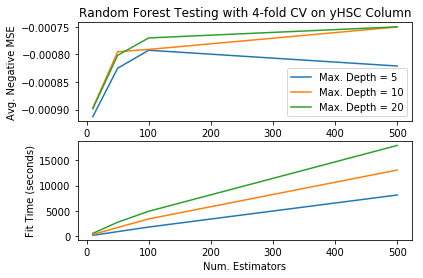

[[10 5 'auto' -91288.24384703636 182.098093688488]
 [50 5 'auto' -82496.33622796193 906.1462435126305]
 [100 5 'auto' -79237.48862426209 1811.7246014475822]
 [500 5 'auto' -82093.28170325953 8128.913308262825]
 [10 5 'sqrt' -108291.01403215966 28.036456763744354]
 [50 5 'sqrt' -95677.37577428004 136.6431884765625]
 [100 5 'sqrt' -92392.66404029544 267.1263865828514]
 [500 5 'sqrt' -88524.32635525007 1327.0757511854172]
 [10 10 'auto' -89717.49269250802 347.48356580734253]
 [50 10 'auto' -79500.84121381067 1722.538121163845]
 [100 10 'auto' -79085.32497149071 3418.06063580513]
 [500 10 'auto' -75015.6906409436 13051.108522295952]
 [10 10 'sqrt' -82685.45231429115 50.58607596158981]
 [50 10 'sqrt' -82971.71200449404 252.67220228910446]
 [100 10 'sqrt' -82421.62294071494 505.50974118709564]
 [500 10 'sqrt' -80539.61473253506 2526.5932250618935]
 [10 20 'auto' -89828.31914605398 564.4461513757706]
 [50 20 'auto' -80149.28923019412 2754.8854860067368]
 [100 20 'auto' -77003.13562690388 4922

In [53]:
results = param_searcher.cv_results_
table = np.vstack((results['param_n_estimators'], results['param_max_depth'],
                   results['param_max_features'], results['mean_test_score'],
                   results['mean_fit_time'])).T
for index in range(3):
    rows = table[8 * index:8 * index + 4]
    plt.subplot(2, 1, 1)
    plt.plot(rows[:, 0], rows[:, 3] * 1e-8)
    plt.subplot(2, 1, 2)
    plt.plot(rows[:, 0], rows[:, 4])
plt.subplot(2, 1, 1)
plt.legend(['Max. Depth = 5', 'Max. Depth = 10', 'Max. Depth = 20'])
plt.title('Random Forest Testing with 4-fold CV on yHSC Column')
plt.ylabel('Avg. Negative MSE')
plt.subplot(2, 1, 2)
plt.xlabel('Num. Estimators')
plt.ylabel('Fit Time (seconds)')
plt.show()
print(table)

In [9]:
print(param_searcher.best_params_)
print(repr(param_searcher.cv_results_))

{'n_estimators': 500, 'max_features': 'auto', 'max_depth': 20}
{'mean_score_time': array([ 0.15533632,  0.59351587,  1.06582814,  3.17024839,  0.14055347,
        0.51219183,  0.94933027,  4.48362738,  0.21841222,  0.88741106,
        1.60965055,  6.12406015,  0.21148258,  0.86483753,  1.66244805,
        7.99679971,  0.61207545,  2.43042189,  4.10550916, 17.80885893,
        0.61375815,  2.9398182 ,  5.76832342, 21.92914808]), 'split3_test_score': array([-220718.13465759, -208750.1979178 , -184965.99140476,
       -197359.1980404 , -278893.61110733, -234005.69600054,
       -236510.78482301, -223101.15193704, -213817.59105994,
       -184787.79278967, -198762.46172844, -186606.38652675,
       -197840.91374183, -215573.26509888, -214118.05109378,
       -209129.27026707, -212673.19462144, -196806.08376574,
       -191170.73694114, -185920.30604801, -240522.46487774,
       -213344.97427014, -217552.50529265, -208934.38081378]), 'params': [{'n_estimators': 10, 'max_features': 'auto', '

In [173]:
import time

while True:
    time.sleep(600)
    print('Hello World')

Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World
Hello World


KeyboardInterrupt: 

In [3]:
cosmos_table = Table.read(cosmos_filename).filled()

In [7]:
zbright_errors = get_zbright_errors(spec_table)

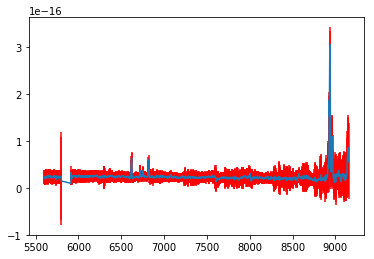

In [237]:
name = 'Magellan'
lambdas, fluxes, flux_errors = read_spec_file(name,
                                              spec_table[spec_table['name'] == name][1000]['path'],
                                              zbright_errors, True)
plt.errorbar(lambdas, fluxes, flux_errors, ecolor='red', zorder=1)
plt.show()

In [290]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

class VAE:
    
    def __init__(self, original_ndim, latent_ndim, intermediate_ndims):        
        # Build the encoder.
        original_input = Input(shape=(original_ndim,))
        prev_layer = original_input
        for intermediate_ndim in intermediate_ndims:
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        latent_mean = Dense(latent_ndim)(prev_layer)
        latent_log_var = Dense(latent_ndim)(prev_layer)
        
        def sample_latent(args):
            # Sample from a normal distribution centered at latent_mean with
            # variance exp(latent_log_var).
            latent_mean, latent_log_var = args
            batch_size = K.shape(latent_mean)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_ndim))
            return latent_mean + K.exp(0.5 * latent_log_var) * epsilon
        
        latent_output = Lambda(sample_latent)([latent_mean, latent_log_var])
        self.encoder = Model(original_input,
                             [latent_mean, latent_log_var, latent_output])

        # Build the decoder.
        latent_input = Input(shape=(latent_ndim,))
        prev_layer = latent_input
        for intermediate_ndim in reversed(intermediate_ndims):
            prev_layer = Dense(intermediate_ndim, activation='relu')(prev_layer)
        original_output = Dense(original_ndim)(prev_layer)
        self.decoder = Model(latent_input, original_output)

        # Build the full auto-encoder.
        restored_input = self.decoder(self.encoder(original_input)[2])
        self.autoencoder = Model(original_input, restored_input)
        
        restoration_loss = mse(original_input, restored_input) * original_ndim
        kl_loss = -K.sum(1 + latent_log_var - K.square(latent_mean) -
                         K.exp(latent_log_var), axis=-1) / 2
        self.autoencoder.add_loss(K.mean(restoration_loss + kl_loss))
        
        self.autoencoder.compile(optimizer='adam')
        
        # Record that no training has occured yet.
        self.last_epoch = 0
        
    def train(self, training_data, validation_data, epochs, backup_name=None):
        self.last_epoch += epochs
        self.autoencoder.fit(training_data, epochs=self.last_epoch,
                             validation_data=(validation_data, None))
        if backup_name:
            self.autoencoder.save_weights(backup_name + '.h5')
        
    def load(self, backup_name):
        self.autoencoder.load_weights(backup_name + '.h5')
    
    def to_latent(self, original):
        return self.encoder.predict(original)[0]
    
    def from_latent(self, latent):
        return self.decoder.predict(latent)

################################################################################

# Visualize the 2D or 3D latent space.
def plot_results(vae, data, labels, filename=None):
    latent_data = vae.to_latent(data)
    fig = plt.figure(figsize=(12, 10))
    if latent_data.shape[1] == 2:
        ax = fig.gca()
    else:
        ax = fig.gca(projection='3d')
    p = ax.scatter(*latent_data.T, c=labels)
    fig.colorbar(p)
    if filename:
        fig.savefig(filename + '.png')
    plt.show()

################################################################################

split_index = int(0.8 * len(colors))

vae = VAE(len(bands), 2, [100, 10])
vae.train(colors[:split_index], colors[split_index:], 1, 'vae_cosmos')

has_specz = np.nan_to_num(speczs) > 0
plot_results(vae, colors[has_specz], speczs[has_specz])

Using TensorFlow backend.
W0712 16:51:59.461615 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 16:51:59.510530 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 16:51:59.538975 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 16:51:59.697676 61144 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0712 16:52:00.111408 61144 deprecation_wrapper

Train on 257293 samples, validate on 64324 samples
Epoch 1/1
 72960/257293 [=======>......................] - ETA: 1:41:58 - loss: 78249744.000 - ETA: 37:00 - loss: 26898034.2708  - ETA: 23:34 - loss: 16235359.646 - ETA: 17:58 - loss: 11626747.066 - ETA: 14:44 - loss: 11607540.351 - ETA: 12:45 - loss: 9619133.165 - ETA: 11:21 - loss: 8142190.53 - ETA: 9:04 - loss: 6230568.3000 - ETA: 8:04 - loss: 5298189.445 - ETA: 7:18 - loss: 4608987.819 - ETA: 6:02 - loss: 3657973.586 - ETA: 4:55 - loss: 2870088.646 - ETA: 4:07 - loss: 2311110.556 - ETA: 3:42 - loss: 2007531.874 - ETA: 3:23 - loss: 1774723.962 - ETA: 3:16 - loss: 1664494.470 - ETA: 3:03 - loss: 1501424.439 - ETA: 2:49 - loss: 1350664.537 - ETA: 2:48 - loss: 1301648.535 - ETA: 2:43 - loss: 1227460.040 - ETA: 2:37 - loss: 1149142.277 - ETA: 2:41 - loss: 1125211.609 - ETA: 2:26 - loss: 1000377.838 - ETA: 2:21 - loss: 939633.952 - ETA: 2:13 - loss: 864723.59 - ETA: 2:07 - loss: 806881.65 - ETA: 2:06 - loss: 783626.99 - ETA: 2:04 - loss:

KeyboardInterrupt: 

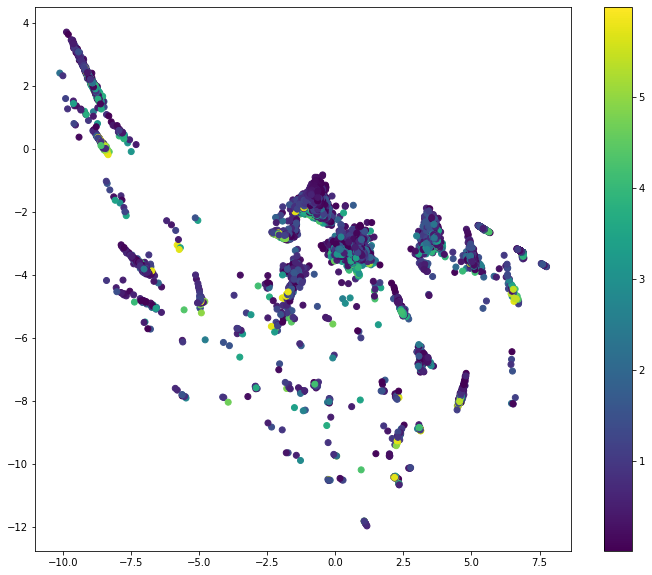

In [97]:
has_photozs= np.nan_to_num(photozs) > 0
plot_results(vae, colors[has_photozs], photozs[has_photozs])